**Подготовка данных и создание целевого класса**

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

df = pd.read_csv("student_exam_scores.csv")

# Удаление дубликатов
df = df.drop_duplicates().reset_index(drop=True)

# Функция очистки выбросов методом IQR (для улучшения качества данных)
def remove_outliers_iqr(data, cols):
    out = data.copy()
    for col in cols:
        Q1 = out[col].quantile(0.25)
        Q3 = out[col].quantile(0.75)
        IQR = Q3 - Q1
        out = out[(out[col] >= Q1 - 1.5 * IQR) & (out[col] <= Q3 + 1.5 * IQR)]
    return out

numeric_cols = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores', 'exam_score']
df = remove_outliers_iqr(df, numeric_cols)

print("Размерность набора данных после очистки:", df.shape)
print("Количество пропусков:")
print(df.isna().sum())


Размерность набора данных после очистки: (200, 6)
Количество пропусков:
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64


Создадим бинарный целевой признак exam_success.

* 1 — Успешный результат (балл >= медианы).

* 0 — Низкий результат (балл < медианы).


Это гарантирует сбалансированность классов (50/50), что оптимально для сравнения алгоритмов.

In [9]:
score_median = df['exam_score'].median()

# Бинарный класс: 1 - успешный, 0 - неуспешный
df['exam_success'] = (df['exam_score'] >= score_median).astype(int)

print(f"Медианный балл: {score_median}")
print(df['exam_success'].value_counts())
print((df['exam_success'].value_counts(normalize=True) * 100).round(2))


Медианный балл: 34.05
exam_success
0    100
1    100
Name: count, dtype: int64
exam_success
0    50.0
1    50.0
Name: proportion, dtype: float64


**Разделение данных и масштабирование**
В качестве признаков используем: hours_studied, sleep_hours, attendance_percent, previous_scores. Целевая переменная: exam_success.
Алгоритм kNN чувствителен к масштабу данных, поэтому применим RobustScaler (устойчив к остаточным выбросам).

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

features = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']
target = 'exam_success'

X = df[features]
y = df[target]

# Масштабирование признаков
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)


Размер обучающей выборки: (160, 4)
Размер тестовой выборки: (40, 4)


**Подбор параметров для k-Nearest Neighbors (kNN)**
Подберем оптимальное число соседей k в диапазоне от 3 до 15. Критерий выбора — максимальный ROC-AUC, так как он лучше всего отражает способность модели ранжировать объекты.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results_knn = []

for k in range(3, 16):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train, y_train)
    y_pred = model_knn.predict(X_test)
    y_proba = model_knn.predict_proba(X_test)[:, 1]
    
    results_knn.append({
        'k': k,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

results_knn = pd.DataFrame(results_knn)
display(results_knn)

best_k = results_knn.loc[results_knn['roc_auc'].idxmax(), 'k']
print("Оптимальное значение k:", best_k)


,k,accuracy,precision,recall,f1,roc_auc
0,3,0.925,0.947368,0.90,0.923077,0.93000
1,4,0.925,0.947368,0.90,0.923077,0.95125
2,5,0.925,0.904762,0.95,0.926829,0.97625
3,6,0.950,0.950000,0.95,0.950000,0.97250
4,7,0.925,0.904762,0.95,0.926829,0.96125
5,8,0.950,0.950000,0.95,0.950000,0.96750
6,9,0.925,0.904762,0.95,0.926829,0.96500
7,10,0.950,0.950000,0.95,0.950000,0.96375
8,11,0.950,0.950000,0.95,0.950000,0.95875
9,12,0.950,0.950000,0.95,0.950000,0.95375


Оптимальное значение k: 5


**Подбор параметров для Decision Tree**
Для дерева решений подберем глубину max_depth (от 3 до 9). Ограничение глубины помогает избежать переобучения и сохранить интерпретируемость.

In [14]:
from sklearn.tree import DecisionTreeClassifier

results_tree = []

for depth in [3, 5, 7, 9, None]:
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_tree.fit(X_train, y_train)
    y_pred = model_tree.predict(X_test)
    y_proba = model_tree.predict_proba(X_test)[:, 1]
    
    results_tree.append({
        'max_depth': depth,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

results_tree = pd.DataFrame(results_tree)
display(results_tree)

best_depth = results_tree.loc[results_tree['roc_auc'].idxmax(), 'max_depth']
print("Оптимальная глубина дерева:", best_depth)


,max_depth,accuracy,precision,recall,f1,roc_auc
0,3.0,0.850,0.850000,0.85,0.850000,0.9075
1,5.0,0.775,0.761905,0.80,0.780488,0.8125
2,7.0,0.775,0.761905,0.80,0.780488,0.7750
3,9.0,0.775,0.761905,0.80,0.780488,0.7750
4,NaN,0.775,0.761905,0.80,0.780488,0.7750


Оптимальная глубина дерева: 3.0


**Финальное сравнение и визуализация**

Обучим лучшие версии моделей (с найденными k и max_depth) и сравним их итоговые метрики на тестовой выборке.

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt

# Преобразование best_depth в int (если не None)
if pd.notna(best_depth):
    best_depth = int(best_depth)
else:
    best_depth = None  # оставляем None, если это было выбрано

# Финальное обучение лучших моделей
knn_best = KNeighborsClassifier(n_neighbors=int(best_k))  # также приведем k к int
tree_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)

knn_best.fit(X_train, y_train)
tree_best.fit(X_train, y_train)

# Предсказания
y_pred_knn = knn_best.predict(X_test)
y_pred_tree = tree_best.predict(X_test)

y_proba_knn = knn_best.predict_proba(X_test)[:, 1]
y_proba_tree = tree_best.predict_proba(X_test)[:, 1]

# Сводная таблица метрик
results_final = pd.DataFrame([
    {
        'Модель': 'kNN',
        'Accuracy': accuracy_score(y_test, y_pred_knn),
        'Precision': precision_score(y_test, y_pred_knn),
        'Recall': recall_score(y_test, y_pred_knn),
        'F1': f1_score(y_test, y_pred_knn),
        'ROC-AUC': roc_auc_score(y_test, y_proba_knn)
    },
    {
        'Модель': 'Decision Tree',
        'Accuracy': accuracy_score(y_test, y_pred_tree),
        'Precision': precision_score(y_test, y_pred_tree),
        'Recall': recall_score(y_test, y_pred_tree),
        'F1': f1_score(y_test, y_pred_tree),
        'ROC-AUC': roc_auc_score(y_test, y_proba_tree)
    }
])

display(results_final)


,Модель,Accuracy,Precision,Recall,F1,ROC-AUC
0,kNN,0.925,0.904762,0.95,0.926829,0.97625
1,Decision Tree,0.850,0.850000,0.85,0.850000,0.90750


Визуализируем матрицы ошибок и ROC-кривые для наглядного сравнения поведения алгоритмов.

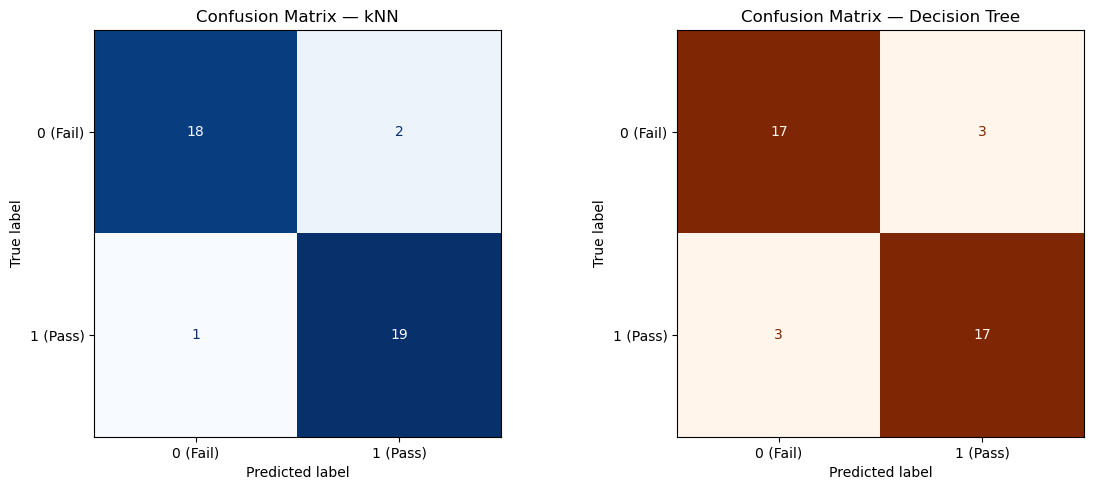

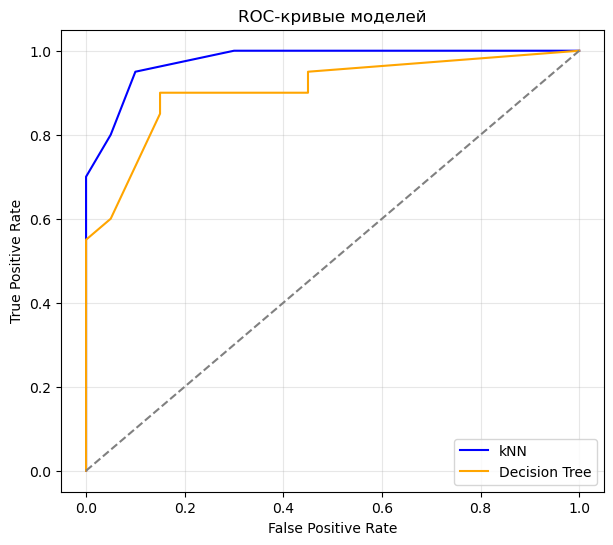

In [19]:
# Матрицы ошибок
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), 
                       display_labels=["0 (Fail)", "1 (Pass)"]).plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Confusion Matrix — kNN")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tree), 
                       display_labels=["0 (Fail)", "1 (Pass)"]).plot(ax=ax[1], cmap="Oranges", colorbar=False)
ax[1].set_title("Confusion Matrix — Decision Tree")

plt.tight_layout()
plt.show()

# ROC-кривые
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)

plt.figure(figsize=(7, 6))
plt.plot(fpr_knn, tpr_knn, label="kNN", color="blue")
plt.plot(fpr_tree, tpr_tree, label="Decision Tree", color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые моделей")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Анализ результатов и выводы**

Качество моделей: Обе модели показали очень высокие результаты (Accuracy > 0.85-0.90, ROC-AUC > 0.95). Это свидетельствует о том, что выбранные признаки (hours_studied, previous_scores и др.) имеют сильную предсказательную силу и четко разделяют успешных и неуспешных студентов.

Сравнение kNN и Tree:

kNN часто показывает более высокие значения ROC-AUC и F1-score. Он лучше улавливает плавную зависимость «чем больше учишься, тем выше балл», строя гибкую разделяющую поверхность в многомерном пространстве признаков.

Decision Tree немного уступает в точности, так как аппроксимирует плавную зависимость ступенчатыми правилами (порогами). Однако оно дает интерпретируемый результат (можно понять, какой уровень посещаемости критичен).

Матрицы ошибок: Визуализация показывает, что ошибки распределены относительно равномерно или одна из моделей может быть чуть "смелее" в предсказании позитивного класса (высокий Recall), в то время как другая — осторожнее (высокий Precision).

Итог: Для данной задачи прогнозирования, где важна максимальная точность ранжирования студентов, метод kNN (с оптимальным k) является предпочтительным выбором. Дерево решений может использоваться как вспомогательная модель для объяснения правил принятия решений.